## Tidy3D Feature Walkthrough

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/Simulation.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/Simulation.ipynb), or just follow along with the output below.

Our first tutorial focuses on illustrating the basic setup, run, and analysis of a ``Tidy3D`` simulation. In this example, we will simulate a plane wave impinging on dielectric slab with a triangular pillar made of a lossy dielectric sitting on top. First, we import everything needed.

In [72]:
# basic ipython configuration (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import h5py

# get the most recent version of tidy3d
!pip install -q --upgrade tidy3d

# tidy3D import
import tidy3d as td
from tidy3d import web

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we initialize some general simulation parameters. We note that the PML layers extend **beyond** the simulation domain, making the total simulation size larger - as opposed to some solvers in which the PML is covering part of the user-defined simulation domain.

In [73]:
# Resolution in x, y, z (points per micron)
resolution = 20

# Simulation domain size (in micron)
sim_size = [4, 4, 4]

# Central frequency and bandwidth of pulsed excitation, in Hz
fcen = 2e14
fwidth = 1e13

# Number of PML layers to use along each of the three directions.
pml_layers = [12, 12, 12]

The run time of a simulation depends a lot on whether there are any long-lived resonances. In our example here, there is no strong resonance. Thus, we do not need to run the simulation much longer than after the sources have decayed. We thus set the run time based on the source bandwidth.

In [74]:
# Total time to run in seconds
run_time = 2/fwidth

### Structures and materials

Next, we initialize the simulated structure. The structure consists of two geometric objects. Each object is made of a material. Note that the size of any object (structure, source, or monitor) can extend beyond the simulation domain, and is truncated at the edges of that domain. For best results with PML layers, structures must extend all the way through the PMLs. In some such cases, an "infinite" size `td.inf` can be used to define the size.

In [75]:
# Lossless dielectric
material1 = td.Medium(epsilon=6.)
# Lossy dielectric defined from the real and imaginary part of the refractive index
material2 = td.Medium.from_nk(n=1.5, k=0.1, freq=fcen)

# Rectangular slab
box = td.Box(center=[0, 0, 0], size=[td.inf, td.inf, 1], material=material1)
# Triangle in the xy-plane with a finite extent in z
equi_tri_verts = [[-1/2, -1/4],
                  [1/2, -1/4],
                  [0, np.sqrt(3)/2 - 1/4]]
poly = td.PolySlab(
    vertices=2*np.array(equi_tri_verts), 
    z_cent=0.75,
    z_size=0.5,
    material=material2)

### Sources

Next, we define a source injecting a normal-incidence plane-wave from above. The time dependence of the source is a Gaussian pulse. A source can be added to multiple simulations. After we add the source to a specific simulation, such that the total run time is known, we can use in-built plotting tools to visualize its time- and frequency-dependence, which we will show below.

In [76]:
psource = td.PlaneWave(
    injection_axis='-z',
    position=1.5,
    source_time = td.GaussianPulse(
        frequency=fcen,
        fwidth=fwidth),
    polarization='y')
print(psource)

Tidy3D PlaneWave:
name            = None
injection_axis  = -z
position        = 1.50
source_time     = GaussianPulse(
    frequency  = 2.00e+14,
    fwidth     = 1.00e+13,
    offset     = 5.00)
polarization    = y
amplitude       = 1.00e+00



### Monitors

Finally, we can also add some monitors that will record the fields that we request during the simulation run. The two main types are time monitors that record the time-domain fields, and frequency monitors that record a running discrete Fourier transform of the fields at a given set of frequencies. Time monitors are best used to monitor the time dependence of the fields at a single point. Spatially large time monitors can lead to a very large amount of data that needs to be stored. Frequency monitors on the other hand are great for investigating the steady-state field distribution in 2D or even 3D regions of the simulation.

In [77]:
time_mnt = td.TimeMonitor(center=[0, 0, 0], size=[0, 0, 0])
freq_mnt1 = td.FreqMonitor(center=[0, 0, -1], size=[20, 20, 0], freqs=[fcen])
freq_mnt2 = td.FreqMonitor(center=[0, 0, 0], size=[20, 0, 20], freqs=[fcen])

### Simulation

Now we can initialize the simulation with all the elements defined above.

In [78]:
# Initialize simulation
sim = td.Simulation(size=sim_size,
                    resolution=resolution, 
                    structures=[box, poly], 
                    sources=[psource],
                    monitors=[time_mnt, freq_mnt1, freq_mnt2],
                    run_time=run_time,
                    pml_layers=pml_layers)

Initializing simulation...
Mesh step (micron): [5.00e-02, 5.00e-02, 5.00e-02].
Simulation domain in number of grid points: [104, 104, 104].
Total number of grid points: 1.12e+06.
Total number of time steps: 2308.
Estimated data size (GB) of monitor monitor_0: 0.0001.
Estimated data size (GB) of monitor monitor_1: 0.0005.
Estimated data size (GB) of monitor monitor_2: 0.0005.


We can check the simulation monitors just to make sure everything looks right.

In [79]:
print(sim.monitors)

[Tidy3D TimeMonitor: {
name     = None
center   = [0.0000, 0.0000, 0.0000]
size     = [0.0000, 0.0000, 0.0000]
t_start  = 0.00e+00,
t_stop   = None
Store E:  True
Store H:  True
}
, Tidy3D FreqMonitor: {
name     = None
center   = [0.0000, 0.0000, -1.0000]
size     = [20.0000, 20.0000, 0.0000]
freqs    = [2.00e+14]
Store E:  True
Store H:  True
}
, Tidy3D FreqMonitor: {
name     = None
center   = [0.0000, 0.0000, 0.0000]
size     = [20.0000, 0.0000, 20.0000]
freqs    = [2.00e+14]
Store E:  True
Store H:  True
}
]


### Visualization functions

We can now use the some in-built plotting functions to make sure that we have set up the simulation as we desire.

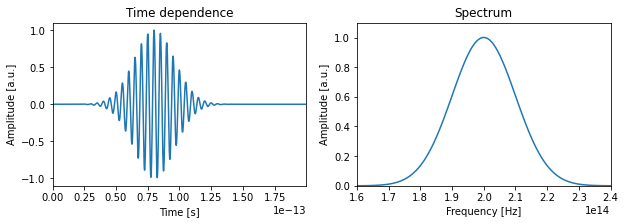

In [80]:
# Visualize source
sim.viz_source(psource)
plt.show()

To visualize the structures in the simulation, we will plot three cross sections at `z=0.75`, `y=0`, and `x=0`, respectively. The relative permittivity of objects is plotted in greyscale. By default, sources are overlayed in green, monitors in yellow, and PML boundaries in orange. The transparency of the overlay can be controlled using `source_alpha`, `monitor_alpha`, and `pml_alpha`. As an example, in the middle plot (`y=0`), we turn off the monitor overlay since the monitor covers the whole cross-section, while in the right-most plot, we make the source more visible.

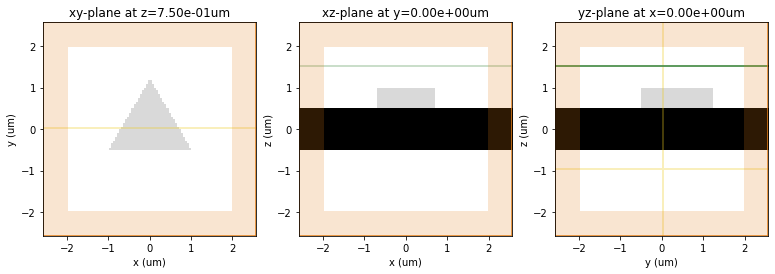

In [92]:
# Set the same color scale in all plots
clim = (1, 6)

fig, ax = plt.subplots(1, 3, figsize=(13, 4))
sim.viz_eps_2D(normal='z', position=0.75, ax=ax[0], clim=clim);
sim.viz_eps_2D(normal='y', ax=ax[1], clim=clim, monitor_alpha=0.);
sim.viz_eps_2D(normal='x', ax=ax[2], clim=clim, source_alpha=0.9);

Alternatively, we can also plot the structures with a fake color based on the material they are made of.

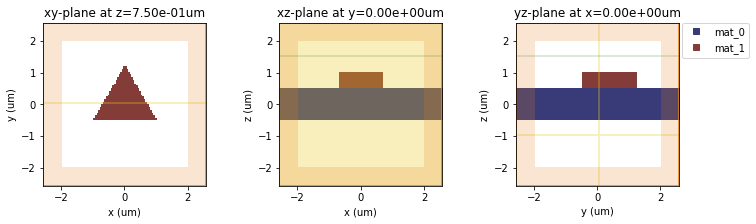

In [94]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sim.viz_mat_2D(normal='z', position=0.75, ax=ax[0]);
sim.viz_mat_2D(normal='y', ax=ax[1], monitor_alpha=0);
sim.viz_mat_2D(normal='x', ax=ax[2], source_alpha=0.9, legend=True);

### Running through the web API

Now that the simulation is constructed, we can run it using the `web` API of ``Tidy3D``. First, we submit the project. Note that we can give it a custom name.

In [12]:
project = web.new_project(sim.export(), task_name='Simulation test')

Uploading the json file...


We can monitor the status of all our projects by listing them in chronological order of submission.

In [13]:
# Check status (of the last 5 submitted projects)
web.list_projects(5)

Project name: Simulation test-8-10
Task ID     : ceb991a5-445b-4239-b0a9-b98ae1978aff
Submit time : 2021:03:18:21:22:22
Status      : queued
--------------------------------------------------
Project name: Simulation test-8-9
Task ID     : 4f1c3b7f-e3ca-4a6a-9060-323ba0894c1c
Submit time : 2021:03:18:19:11:28
Status      : success
--------------------------------------------------
Project name: Simulation test-8-8
Task ID     : f27a037c-9f5a-4837-9b58-9f6aaf14c758
Submit time : 2021:03:18:19:08:19
Status      : success
--------------------------------------------------
Project name: Simulation test-8-7
Task ID     : 5879cdc1-ee86-47fe-8018-ccd962842b8b
Submit time : 2021:03:18:19:00:40
Status      : success
--------------------------------------------------
Project name: L3 high res-18
Task ID     : 0c4bf367-b68c-425a-b928-e8e58be744d6
Submit time : 2021:03:16:20:19:01
Status      : success
--------------------------------------------------


Or, we can continously monitor the status of the current project, and wait until the run is successful. The `monitor_project()` function will keep running until either a `'success'` or `'error'` status is returned.

In [14]:
web.monitor_project(project['taskId'])

Project "Simulation test-8-10" status: success...        



## Loading and analyzing data

After a successful run, we can download the results and load them into our simulation model. We use the `download_results` function from our web API, which downloads a single `hdf5` file containing all the monitor data, a log file, and a `json` file defining the original simulation (same as what you'll get if you run `sim.export_json()` on the current object). Optionally, you can provide a folder in which to store the files. In the example below, the results are stored in the `out` folder. 

In [15]:
web.download_results(project['taskId'], target_folder='out/')
# Show the output of the log file
!cat out/tidy3d.log

Simulation domain Nx, Ny, Nz: 104, 104, 104.
Total number of computational grid points: 1.12e+06.
Total number of time steps: 2308.
Starting Tidy3D... 

Setup time (s): 0.0369
- Time step    115  (  5 % done), field decay: 1.00e+00
- Time step    230  ( 10 % done), field decay: 1.00e+00
- Time step    346  ( 15 % done), field decay: 1.00e+00
- Time step    461  ( 20 % done), field decay: 1.00e+00
- Time step    576  ( 25 % done), field decay: 1.00e+00
- Time step    692  ( 30 % done), field decay: 1.00e+00
- Time step    807  ( 35 % done), field decay: 1.00e+00
- Time step    923  ( 40 % done), field decay: 1.00e+00
- Time step   1038  ( 45 % done), field decay: 9.96e-01
- Time step   1153  ( 50 % done), field decay: 7.37e-01
- Time step   1269  ( 55 % done), field decay: 4.53e-01
- Time step   1384  ( 60 % done), field decay: 2.26e-01
- Time step   1500  ( 65 % done), field decay: 1.03e-01
- Time step   1615  ( 70 % done), field decay: 3.30e-02
- Time step   1730  ( 75 % done), field 

### Load a simulation from JSON file

In case we are returning to a project for which we do not have an active simulation object, we can re-initialize the simulation from the freshly downloaded `json` file. Below, we load the file from the project we just ran, and load the ouput data downloaded from the server.

**NB**: when running the notebook from the beginning, it is not needed to call `import_json()`, as the current Simulation is stored in memory. Here we do it to illustrate how this function can be used, essentially re-initializing the same Simulation.

In [16]:
sim = td.Simulation.import_json("out/simulation.json")
sim.load_results('out/monitor_data.hdf5')

Initializing simulation...
Mesh step (micron): [5.00e-02, 5.00e-02, 5.00e-02].
Simulation domain in number of grid points: [104, 104, 104].
Total number of grid points: 1.12e+06.
Total number of time steps: 2308.
Estimated data size (GB) of monitor monitor_0: 0.0001.
Estimated data size (GB) of monitor monitor_1: 0.0005.
Estimated data size (GB) of monitor monitor_2: 0.0005.
Applying source normalization to all frequency monitors using source index 0.


### Visualization functions

Finally, we can now use the in-built visualization tools to examine the results. Below, we plot the `y`-component of the field recorded by the two frequency monitors (this is the dominant component since the source is `y`-polarized).

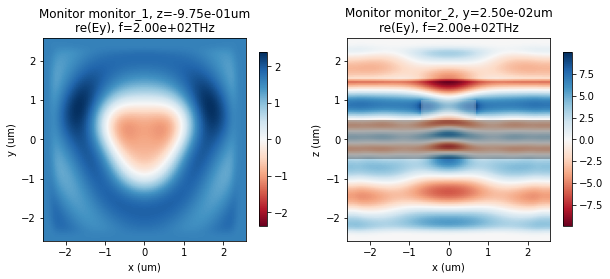

In [17]:
monitors = sim.monitors

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim.viz_field_2D(monitors[1], ax=ax[0], cbar=True, comp='y', val='re');
sim.viz_field_2D(monitors[2], ax=ax[1], cbar=True, comp='y', val='re');

### Monitor data in Simulation object and in hdf5 file
The raw data is also accessible as numpy arrays and can be queried using `sim.data(monitor)`. 

In [18]:
mdata = sim.data(monitors[1])
print("Shape of E-field array stored in monitor 1: ", mdata['E'].shape)
print("Size of corresponding mesh in x           : ", mdata['xmesh'].size)
print("Size of corresponding mesh in y           : ", mdata['ymesh'].size)
print("Size of corresponding mesh in z           : ", mdata['zmesh'].size)
print("Number of frequencies                     : ", mdata['freqs'].size)

Shape of E-field array stored in monitor 1:  (3, 104, 104, 1, 1)
Size of corresponding mesh in x           :  104
Size of corresponding mesh in y           :  104
Size of corresponding mesh in z           :  1
Number of frequencies                     :  1


We can use this raw data for example to also plot the time-domain fields recorded in the TimeMonitor, which look largely like a delayed version of the source input, indicating that no resonant features were excited.

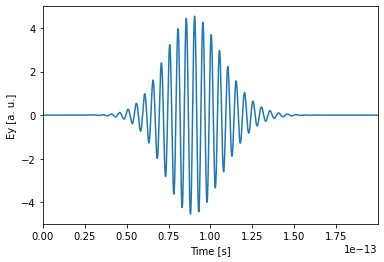

In [19]:
fig, ax = plt.subplots(1)
tdata = sim.data(monitors[0])
tmesh = tdata['tmesh']
ax.plot(tmesh, tdata['E'][1, 0, 0, 0, :])
ax.set_xlim(tmesh[0], tmesh[-1])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Ey [a. u.]")
plt.show()

Finally, the raw data is also accessible through the `hdf5` file. 

In [20]:
# Open the data file and print stored groups and datasets
data_file = h5py.File("out/monitor_data.hdf5", "r")
print("Data groups stored in file:   ", list(data_file.keys()))
print("Datasets in 'monitor_2': ", list(data_file['monitor_2'].keys()))

# Read the E-field of the second FreqMonitor
E_hdf5 = np.array(data_file['monitor_2']['E'])
x_hdf5 = np.array(data_file['monitor_2']['xmesh'])
y_hdf5 = np.array(data_file['monitor_2']['ymesh'])
z_hdf5 = np.array(data_file['monitor_2']['zmesh'])

# Close the file
data_file.close()

Data groups stored in file:    ['diverged', 'monitor_0', 'monitor_1', 'monitor_2']
Datasets in 'monitor_2':  ['E', 'H', 'freqs', 'indspan', 'tmesh', 'xmesh', 'ymesh', 'zmesh']


### Permittivity data

We can also query the relative permittivity in the simulation within a volume of a given `center` and `size`. The method [Simulation.epsilon](../generated/tidy3d.Simulation.epsilon.rst) returns the permittivity at all Yee grid locations inside the specified volume. Instead of manually setting a volume, we can also input a monitor, in which case the fields in that monitor volume are returned.

In [21]:
eps, mesh = sim.epsilon(freq_mnt2)

The permittivity data is returned at the same locations that the E field at which the E field is stored in the monitor.

In [22]:
print("Shape of permittivity array (x, y, z)              : ", eps.shape)
print("Shape of E-field (polarization, x, y, z, frequency): ", E_hdf5.shape)

Shape of permittivity array (x, y, z)              :  (104, 1, 104)
Shape of E-field (polarization, x, y, z, frequency):  (3, 104, 1, 104, 1)


We can use this data to approximately reproduce the figure we get from the built-in visualization. Note that in the in-build function, permittivity of 1 (vacuum) is automatically made fully transparent.

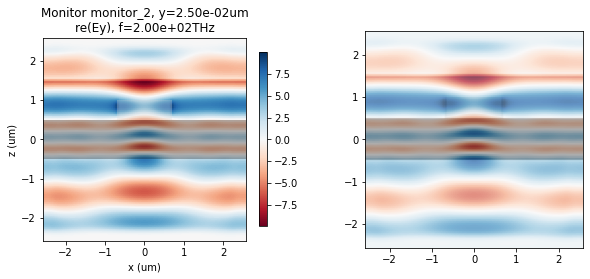

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Built-in Tidy3D viz
sim.viz_field_2D(sim.monitors[2], ax=ax[0], cbar=True, comp='y', val='re', eps_alpha=0.3);

# Manually from data loaded from the hdf5 file
ax[1].imshow(np.real(E_hdf5[1, :, 0, :, 0]).T, cmap='RdBu', origin='lower',
                 extent=[x_hdf5[0], x_hdf5[-1], z_hdf5[0], z_hdf5[-1]])
# Overlay the permittivity data
ax[1].imshow(np.real(eps[:, 0, :]).T, alpha=0.3,
                 extent=[mesh[0][0], mesh[0][-1], mesh[2][0], mesh[2][-1]],
                 origin='lower', cmap='Greys')
plt.show()